In [37]:
# A simple MLP implementation that learns addition of two numbers

In [1]:
import torch
import numpy as np
from sklearn.metrics import mean_squared_error
from numpy import sqrt
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Dataset class. Prepare the dataset, normalize the inputs and targets, split into training and testing subsets

class AddDataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        
        # Normalize the dataset using Z norm
        self.x = (x - np.mean(x)) / np.std(x) 
        self.y = (y - np.mean(y)) / np.std(y) 
        
        # Alternatively can normalize dividing input and target by their respective max values
        #self.x = x / np.max(x) 
        #self.y = y / np.max(y)
        
        self.x = self.x.astype('float32')
        self.y = self.y.reshape(len(y), 1)
        self.y = self.y.astype('float32')
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return [self.x[idx], self.y[idx]]
    
    def get_splits(self, n_test = 0.33):
        test_size = round(n_test * len(self.x))
        train_size = len(self.x) - test_size
        
        return torch.utils.data.random_split(self, [train_size, test_size]) 
    
    def prepare_dataset(self):
        train, test = self.get_splits()
        train_dl = torch.utils.data.DataLoader(train, batch_size=4, shuffle=True) # Test with larger batch numbers
        test_dl = torch.utils.data.DataLoader(test, batch_size=32, shuffle=False)
        
        return train_dl, test_dl
        

In [3]:
# Multi-layer Perceptron model with 3 hidden layers

class MLP(torch.nn.Module):
    def __init__(self, n_inputs):
        super(MLP, self).__init__()        
        self.hidden1 = torch.nn.Sequential(torch.nn.Linear(n_inputs, 200), torch.nn.Sigmoid())
        self.hidden2 = torch.nn.Sequential(torch.nn.Linear(200, 100), torch.nn.Sigmoid())        
        self.hidden3 = torch.nn.Sequential(torch.nn.Linear(100, 20), torch.nn.Sigmoid())
        self.output = torch.nn.Sequential(torch.nn.Linear(20,1))
    
    def forward(self, X):
        X = self.hidden1(X)
        X = self.hidden2(X)
        X = self.hidden3(X)
        X = self.output(X)

        return X

In [4]:
# Train the model

def train_model(train_dl, model, num_of_epochs=30):    
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # Adam optimizer performs better compared to SGD
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95) # Learning rate scheduler

    #optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.1) # SGD optimizer
    error = [] # Collect errors for plotting
    lrs = []
    model.train()
    
    for epoch in range(1, num_of_epochs+1): # Train for the specified number of epochs
        for i, (inputs, targets) in enumerate(train_dl):        
            optimizer.zero_grad()
            y_hat = model(inputs)
            loss = criterion(y_hat, targets)
            loss.backward()
            optimizer.step()
            
        error.append(np.mean(loss.item())) 
        lrs.append(optimizer.param_groups[0]["lr"])
        scheduler.step()
        
        if epoch % 5 == 0 or epoch == num_of_epochs: # Print loss at every 5th epoch
            print(f"Epoch {epoch}, Loss: {loss.item()}, LR: {optimizer.param_groups[0]['lr']:.5f}")
        
    plt.plot(error, label='Loss') 
    plt.plot(lrs, label='Lr') 
    plt.legend(loc='upper left')
    plt.xlabel('Epoch')
    plt.title('Model results')
    plt.show()

In [5]:
# Evaluate the model

def evaluate_model(test_dl, model):
    model.eval()
    predictions, actuals = list(), list()
    for i, (inputs, targets) in enumerate(test_dl):
        y_hat = model(inputs)
        y_hat = y_hat.detach().numpy()
        actual = targets.numpy()
        actual = actual.reshape((len(actual), 1))
        
        predictions.append(y_hat)
        actuals.append(actual)
        
    predictions, actuals = np.vstack(predictions), np.vstack(actuals)
    mse = mean_squared_error(actuals, predictions)
    
    return mse

In [6]:
# Predict the output

def predict(row, model):
    row = torch.Tensor([row]) # Convert row to Torch tensor format
    row_norm = (row - np.mean(x)) / np.std(x) # normalise the input using Z norm
    y_hat = model(row_norm)
    y_hat = y_hat.detach().numpy()
    y_hat_norm = np.std(y) * y_hat + np.mean(y) # De-normalise the output 
    
    return y_hat_norm
    

In [7]:
# Initialise the model's linear layer weights

def init_weights(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

In [8]:
# Create the dataset containing two numbers as input and addition result as output

x = []
y = np.zeros(5000) # sample size

max_range = 1000 # upper number limit

for d in range(len(y)):
    x.append([np.random.randint(1,max_range), np.random.randint(1,max_range)]) # Trained on ranges between 0 to 1000. 

    y[d] = x[d][0] + x[d][1] 

x = np.array(x)

In [9]:
# Review the dataset

print(f"input: {x[1]}, output: {y[1]}") 

input: [245 626], output: 871.0


In [10]:
dataset = AddDataset(x, y) # Create ataset class

In [11]:
train_dl, test_dl = dataset.prepare_dataset() # Prepare dataset with train and test subsets

In [12]:
print(len(train_dl), len(test_dl)) # Check the length of training and testing batch sizes

838 105


In [13]:
# Create MLP model with inputs of length 2. Initialize model weights
model = MLP(2) 
init_weights(model)

Epoch 5, Loss: 0.0003375782398506999, LR: 0.00077
Epoch 10, Loss: 0.000493926927447319, LR: 0.00060
Epoch 15, Loss: 3.296113391115796e-06, LR: 0.00046
Epoch 20, Loss: 2.2047128368285485e-05, LR: 0.00036
Epoch 25, Loss: 3.4770660022331867e-06, LR: 0.00028
Epoch 30, Loss: 1.7288841718254844e-06, LR: 0.00021
Epoch 35, Loss: 2.4488380745424365e-07, LR: 0.00017
Epoch 40, Loss: 9.110985956795048e-06, LR: 0.00013


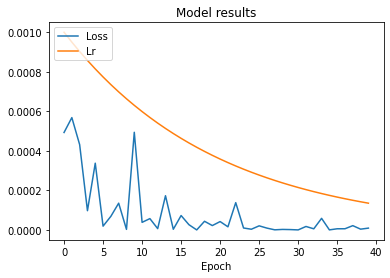

In [14]:
# Train the model for 30 epochs
train_model(train_dl, model, 40)

In [15]:
# Evaluate the model using mean square error and root mean square error
mse = evaluate_model(test_dl, model)
print("MSE: %.3f, RMSE: %.3f" % (mse, sqrt(mse)))

MSE: 0.000, RMSE: 0.001


In [16]:
# Test learned addition with few random samples 
sample = []
predicted = []
actual = []
error = []

for g in range(0,10):
    sample.append(np.array([np.random.randint(1,max_range), np.random.randint(1,max_range)]))
    predicted.append(predict(sample[g], model).item())
    actual.append(sample[g][0] + sample[g][1])
    error.append(mean_squared_error([predicted], [actual]))
    
table = {'Input': sample, 
        'Predicted:': predicted,
        'Actual': actual,
        'Error': error
       }
pd.set_option("display.precision", 3)
df = pd.DataFrame(table)
display(df)

,Input,Predicted:,Actual,Error
0,"[862, 208]",1070.194,1070,0.038
1,"[154, 27]",181.674,181,0.246
2,"[854, 338]",1192.070,1192,0.166
3,"[868, 249]",1117.203,1117,0.135
4,"[136, 586]",721.533,722,0.151
5,"[486, 782]",1267.836,1268,0.131
6,"[555, 812]",1366.964,1367,0.112
7,"[555, 303]",858.186,858,0.102
8,"[356, 418]",774.066,774,0.092
9,"[158, 119]",276.558,277,0.102


In [60]:
# Manually test a sample of numbers between 1-15
x1 = 991
x2 = 135
print("%.3f " % predict(np.array([x1,x2]), model).item(), (x1+x2))

1126.294  1126
